# Gesture Recognizer
Imagine working for a company that would like to use the phone as an input device to an interactive video game system like the XBox or Playstation--for example, using the phone as a paddle in tennis or as a "ball" in bowling. In this project, I built my own 3D gesture recognizer to automatically recognize these gestures.

While in the "real world" you would ultimately need to create a real-time gesture recognizer, this is an offline version in Jupyter Notebook. There are two regonizers: 
(i) a shape-matching recognizer
    Euclidean distance metric and Dynamic Time Warping
(ii) a feature-based (or model-based) recognizer using a support-vector machine (SVM) 

The gestures were recorded with the [A2: Gesture Logger](https://github.com/jonfroehlich/CSE590Sp2018/tree/master/A02-GestureLogger).


## Getting Started
1. The first thing you need to do is to ensure the logPath variable to points to the directory with your gesture logs. Scroll down to the "Load the Data" cell
2. Then, you should be able to select Cell->Run All in the File Menu above and the data should be read in.
3. Note that the Dynamic Time Warping (DTW) API can be slow (up to 25 minutes), the code will print progress updates. 

In [886]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
    
        self.xorig = x.astype(float)
        self.yorig = y.astype(float)
        self.zorig = z.astype(float)
   
        self.magorig = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Gyroscope", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [887]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        #print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

In [888]:
# Load the data

# You should change the path to the location of the log files on your system

logPath_providedGestures = './JonGestureLogs'
logPath_myGestures = './MyGestureLogs'

mapGestureToTrials_provided = parse_and_create_gesture_trials(logPath_providedGestures)
mapGestureToTrials_mine = parse_and_create_gesture_trials(logPath_myGestures)

Found 100 csv files in ./JonGestureLogs
Found 10 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match
Found 110 csv files in ./MyGestureLogs
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'My Custom Gesture'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length a

In [889]:
# let's plot all of the gyro signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)

def plot_gyro_signals( mapGestureToTrials, titleOfPlot):
    print(titleOfPlot)
    fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
    fig.subplots_adjust(hspace=0.5)

    index = 0
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName]

        trialNum = 1
        for trial in gestureTrials:
            axes[index][0].plot(trial.gyro.x, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][1].plot(trial.gyro.y, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][2].plot(trial.gyro.z, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][3].plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
            trialNum = trialNum + 1

        axes[index][0].set_title(gestureName + " (Gyro X)")
        axes[index][0].legend()

        axes[index][1].set_title(gestureName + " (Gyro Y)")
        axes[index][1].legend()

        axes[index][2].set_title(gestureName + " (Gyro Z)")
        axes[index][2].legend()

        axes[index][3].set_title(gestureName + " (Gyro Mag)")
        axes[index][3].legend()
        index = index + 1

    
# Now let's plot all of the accel signals! :)
def plot_accel_signals( mapGestureToTrials, titleOfPlot):
    print(titleOfPlot)
    fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
    fig.subplots_adjust(hspace=0.5)

    index = 0
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName]

        trialNum = 1
        for trial in gestureTrials:
            axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
            trialNum = trialNum + 1

        axes[index][0].set_title(gestureName + " (Accel X)")
        axes[index][0].legend()

        axes[index][1].set_title(gestureName + " (Accel Y)")
        axes[index][1].legend()

        axes[index][2].set_title(gestureName + " (Accel Z)")
        axes[index][2].legend()

        axes[index][3].set_title(gestureName + " (Accel Mag)")
        axes[index][3].legend()
        index = index + 1

Gryoscope plot of Provided Gestures


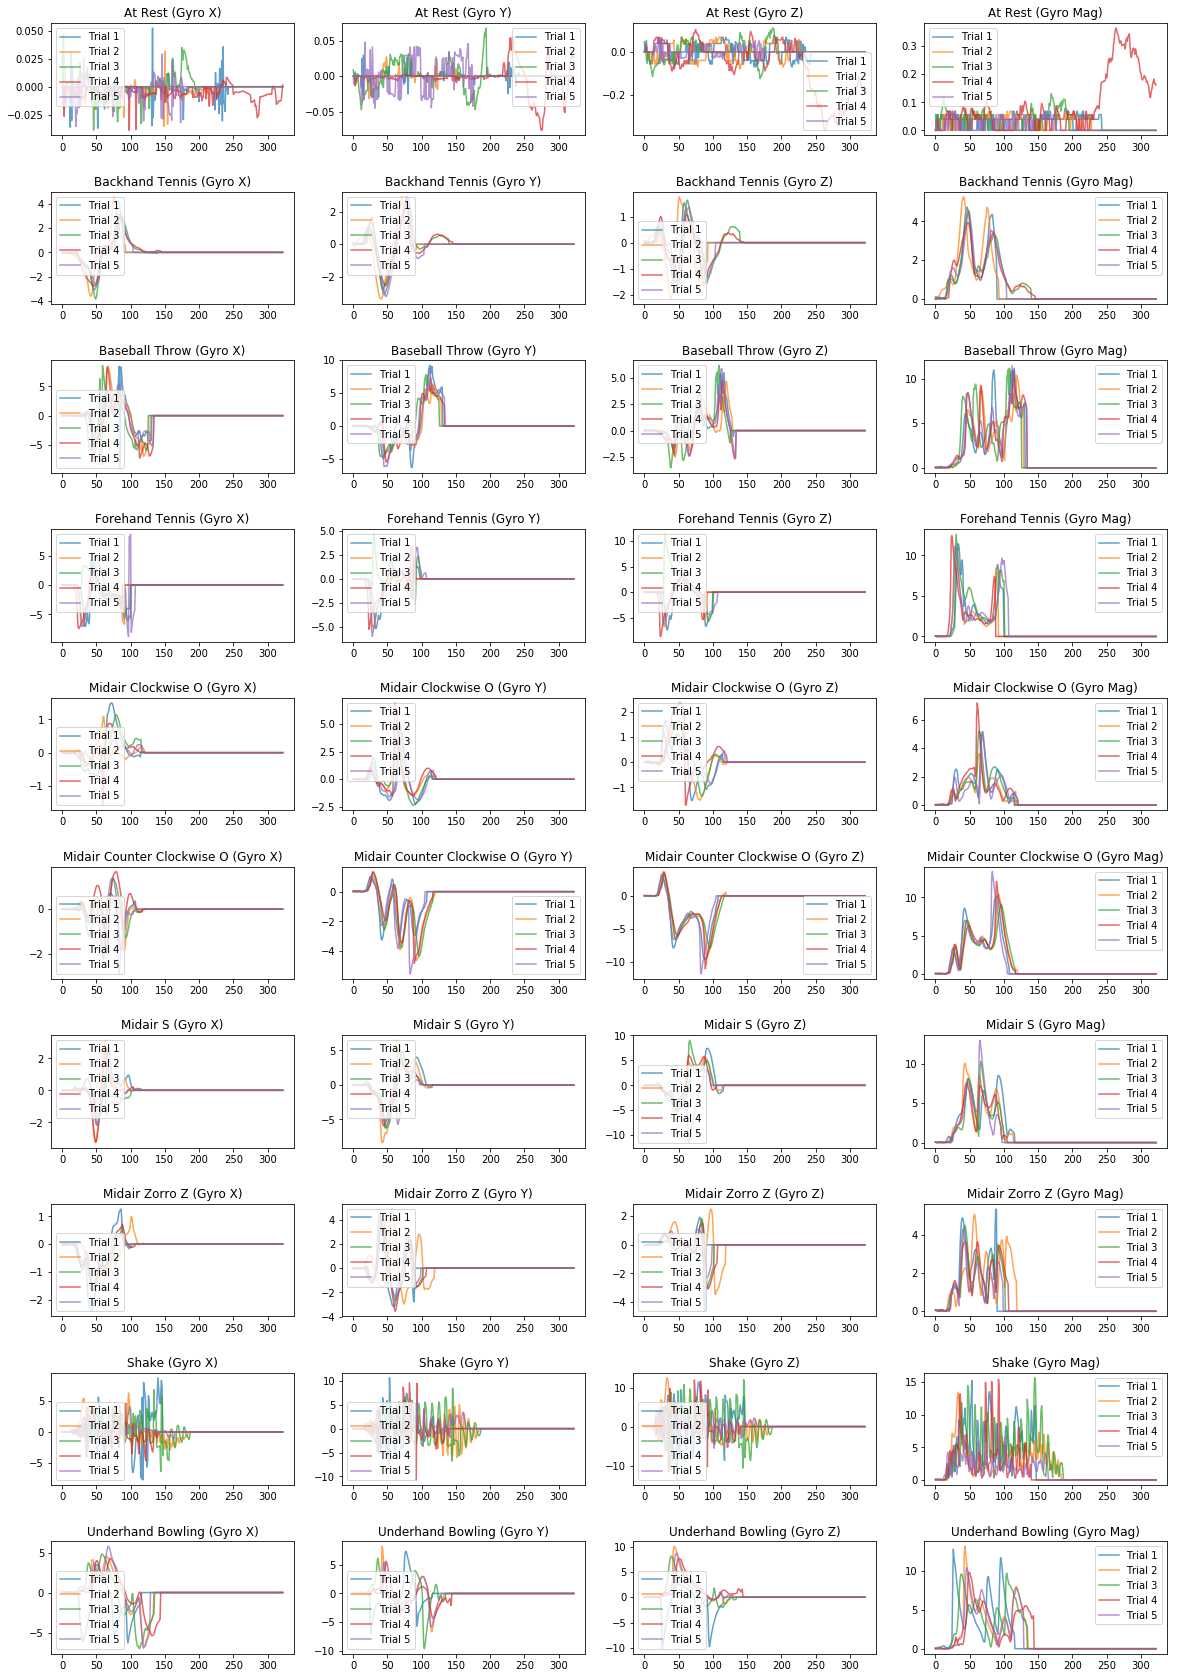

In [890]:
plot_gyro_signals( mapGestureToTrials_provided, "Gryoscope plot of Provided Gestures")

Accelerometer plot of Provided Gestures


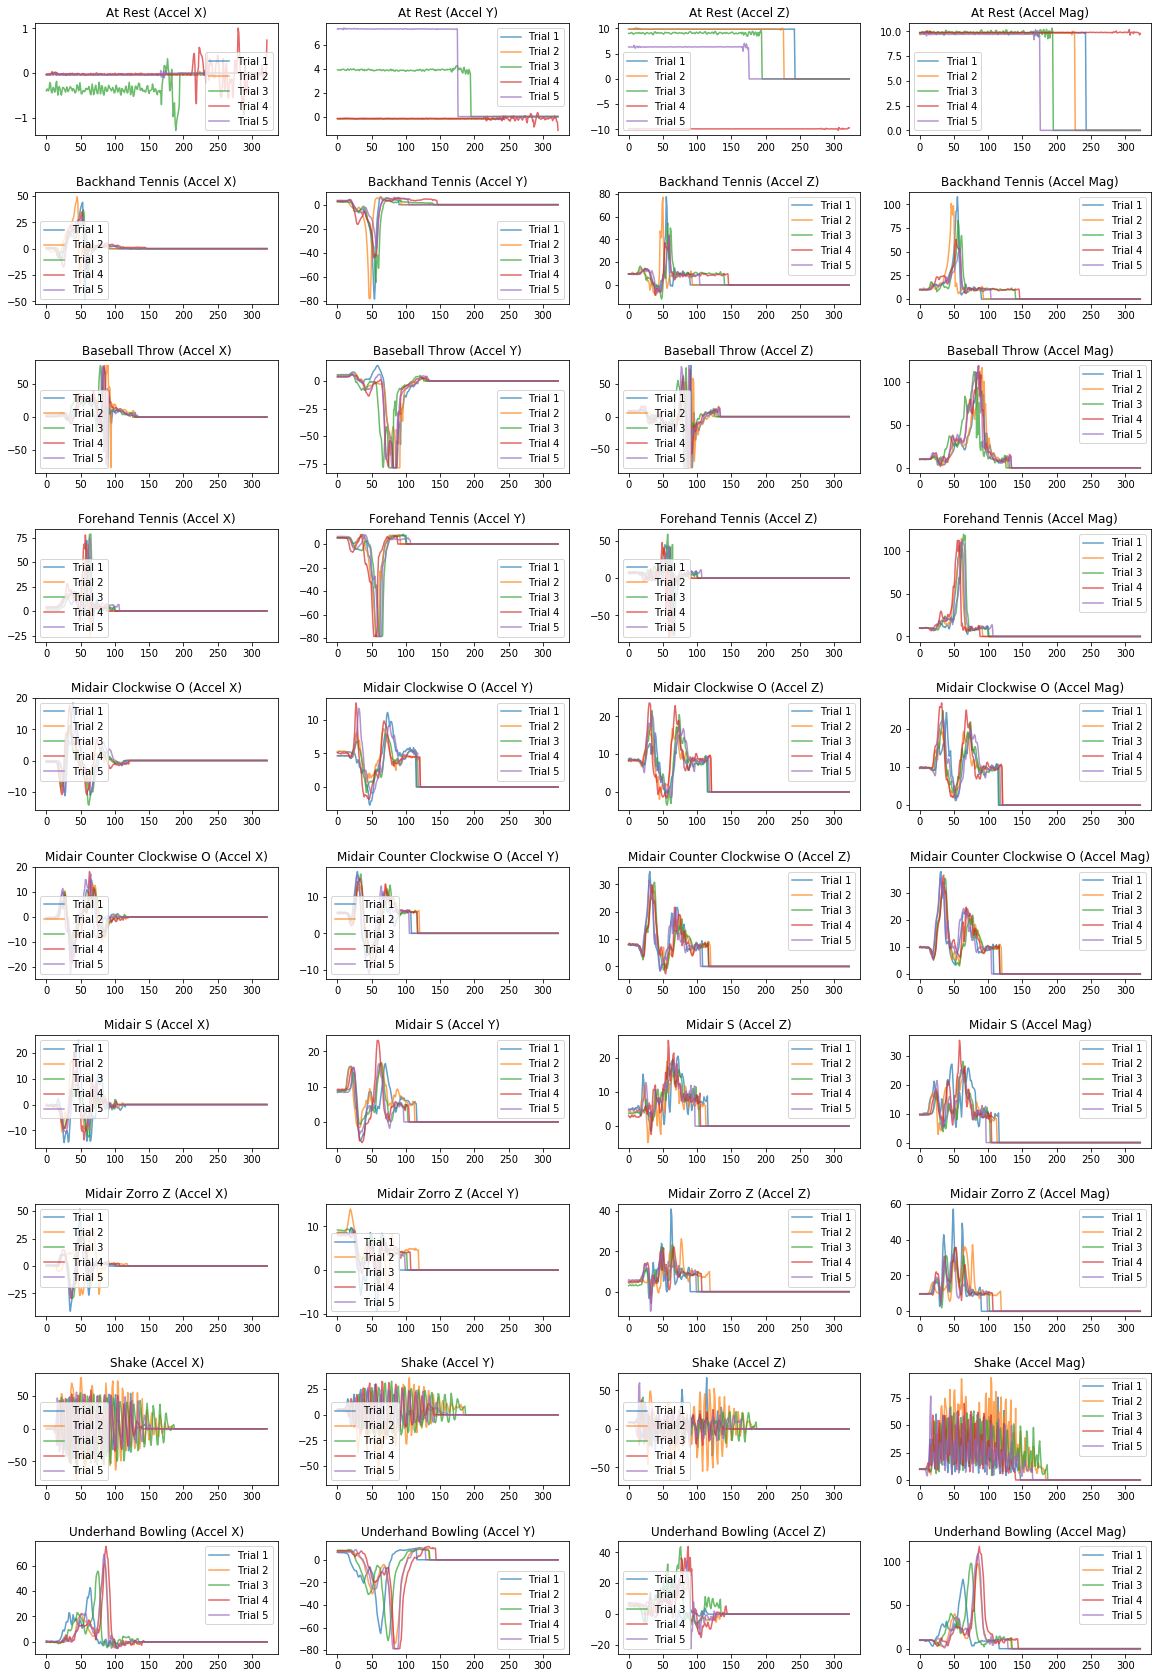

In [891]:
plot_accel_signals( mapGestureToTrials_provided, "Accelerometer plot of Provided Gestures")

Gryoscope plot of My Gestures


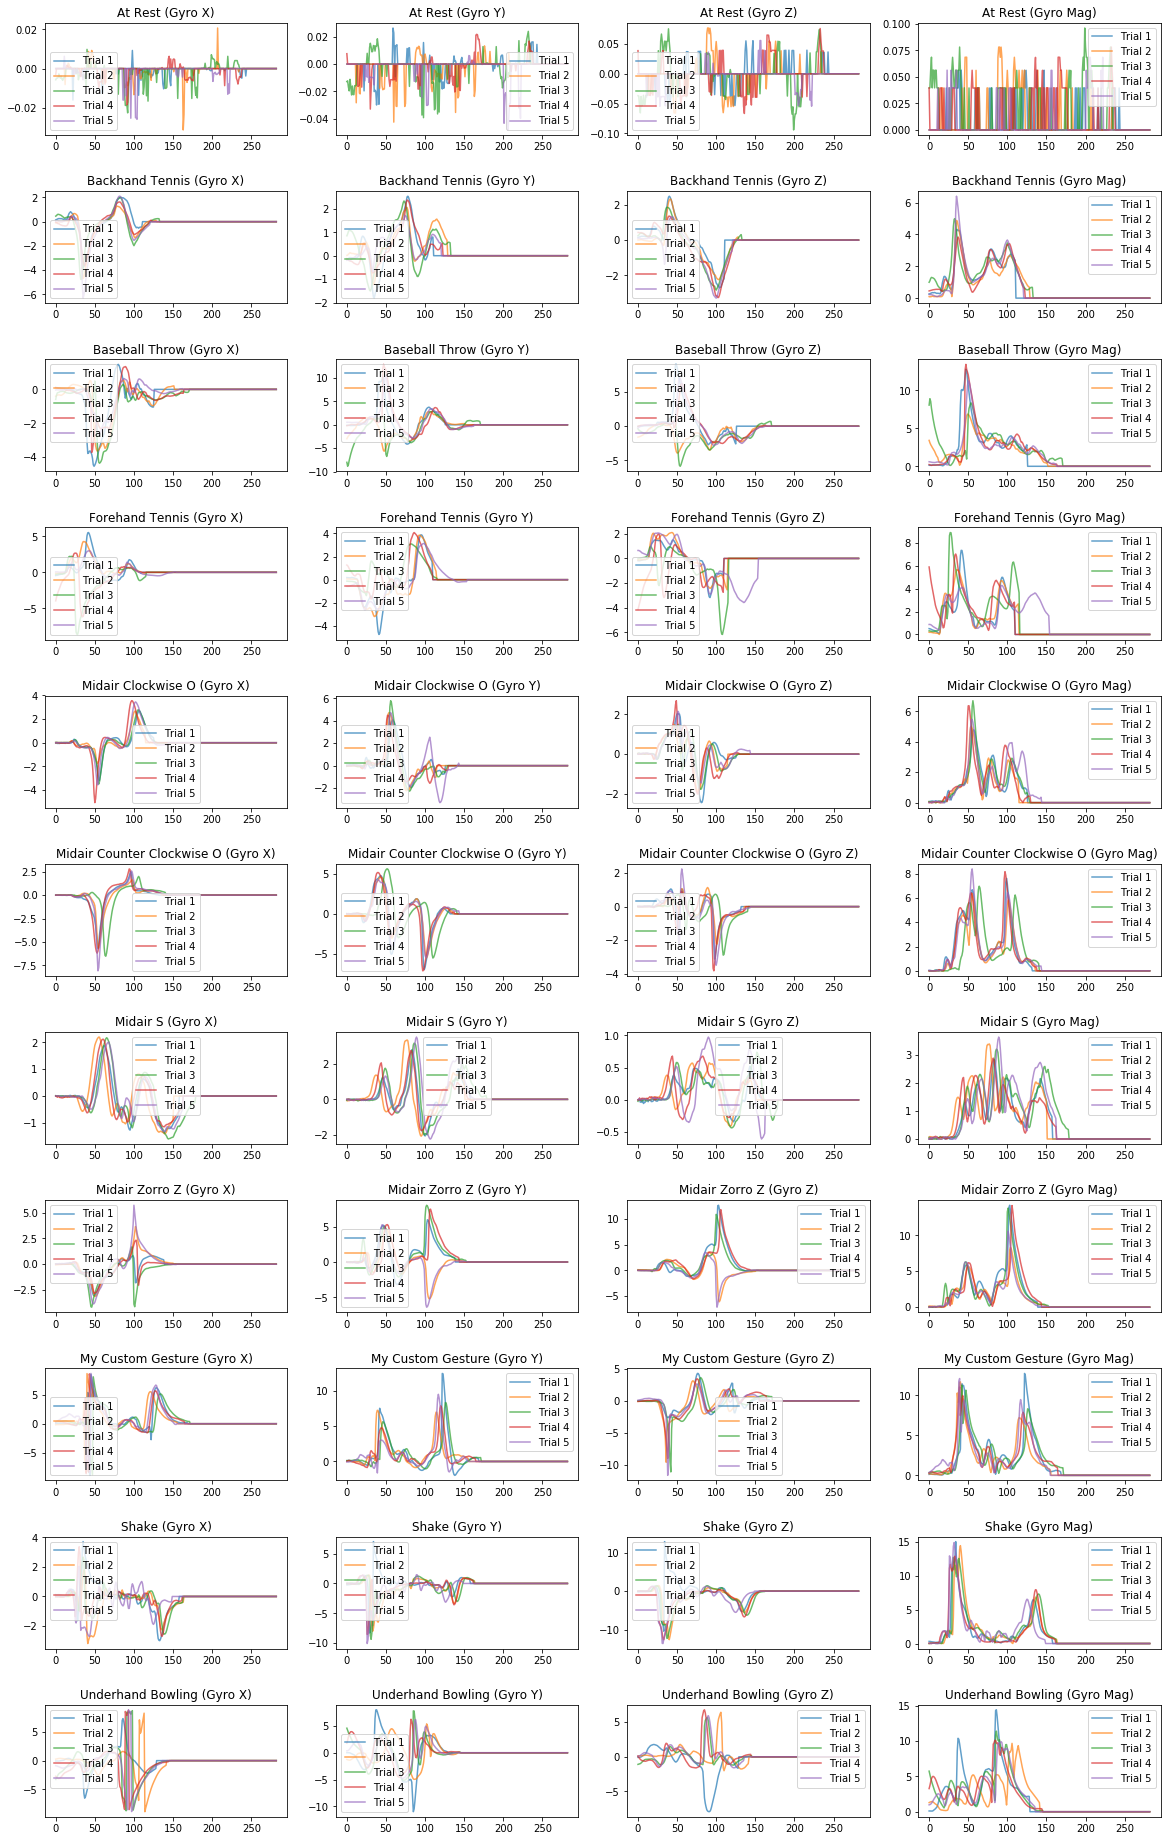

In [892]:
plot_gyro_signals( mapGestureToTrials_mine, "Gryoscope plot of My Gestures")

Accelerometer plot of My Gestures


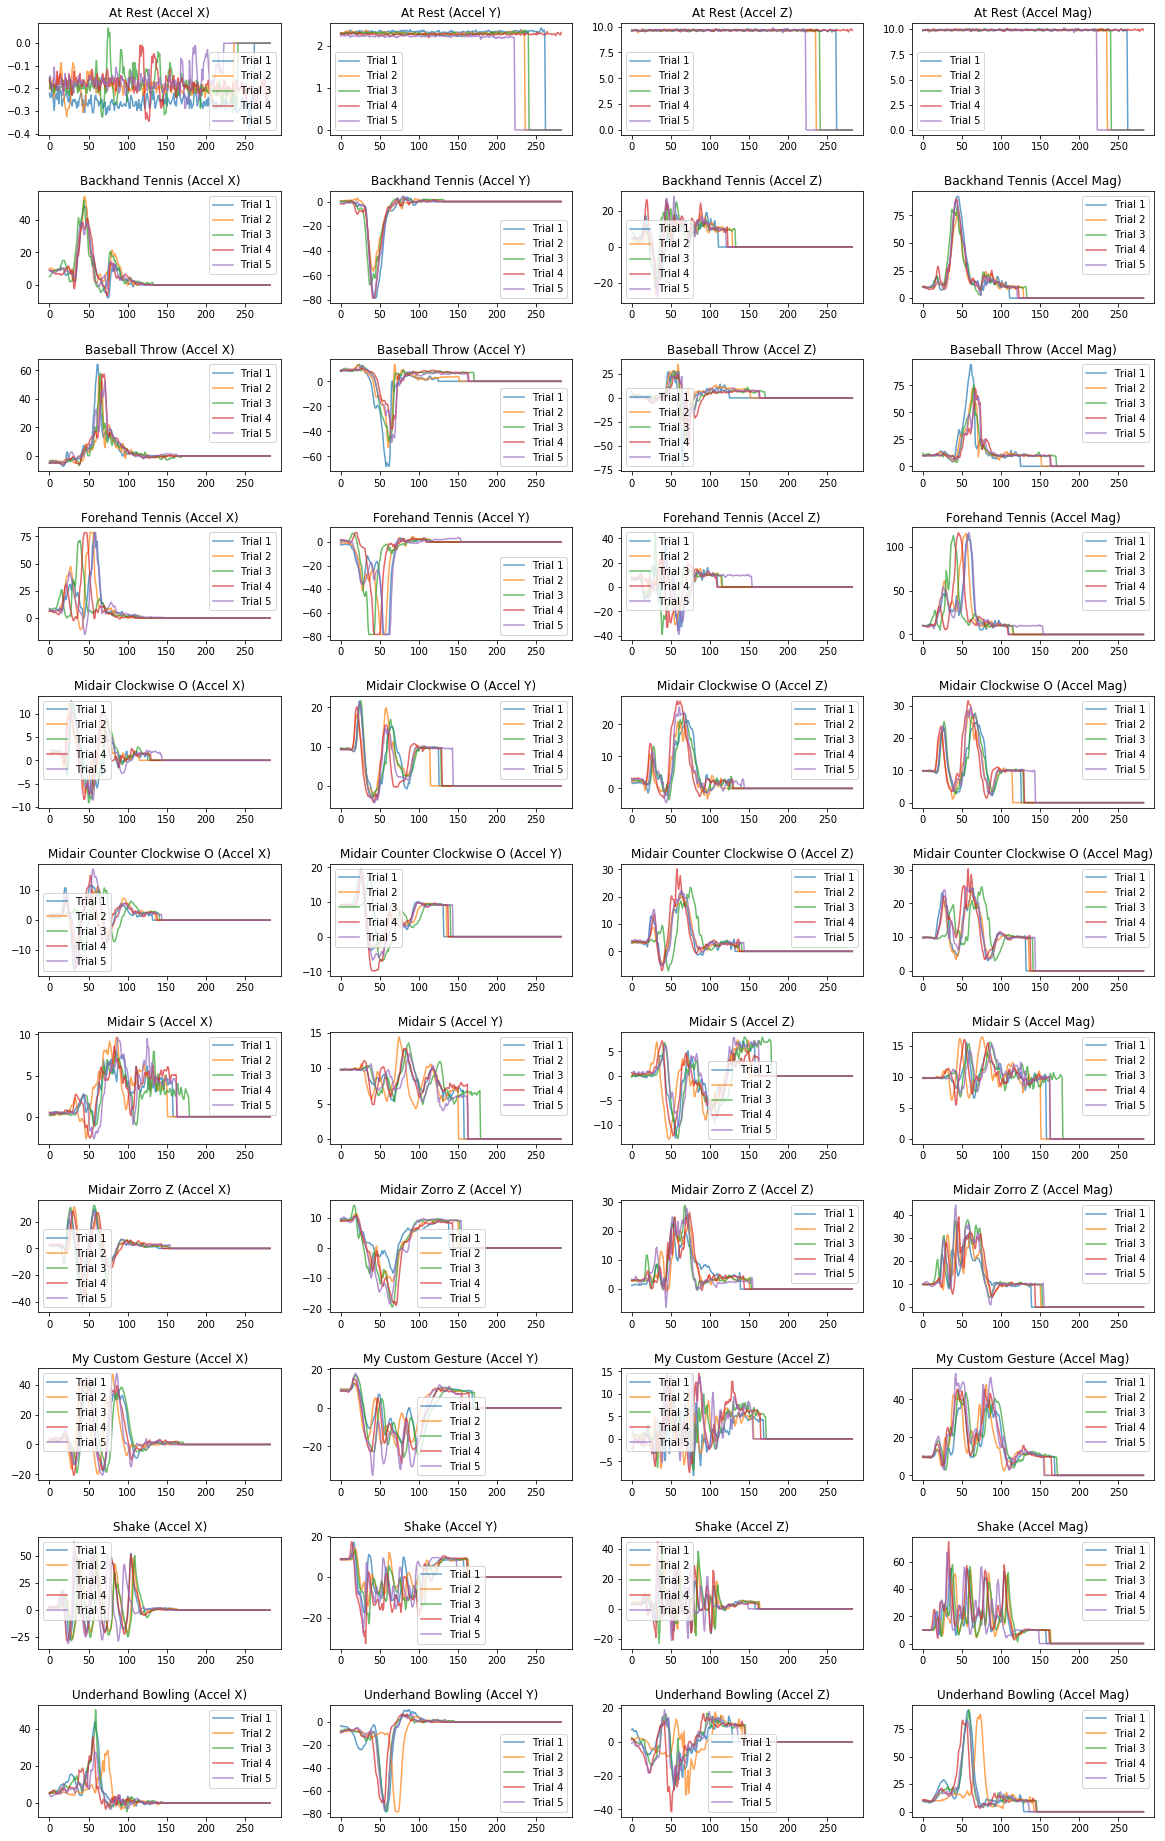

In [893]:
plot_accel_signals( mapGestureToTrials_mine, "Accelerometer plot of My Gestures")

FFT Plots of Provided Gestures


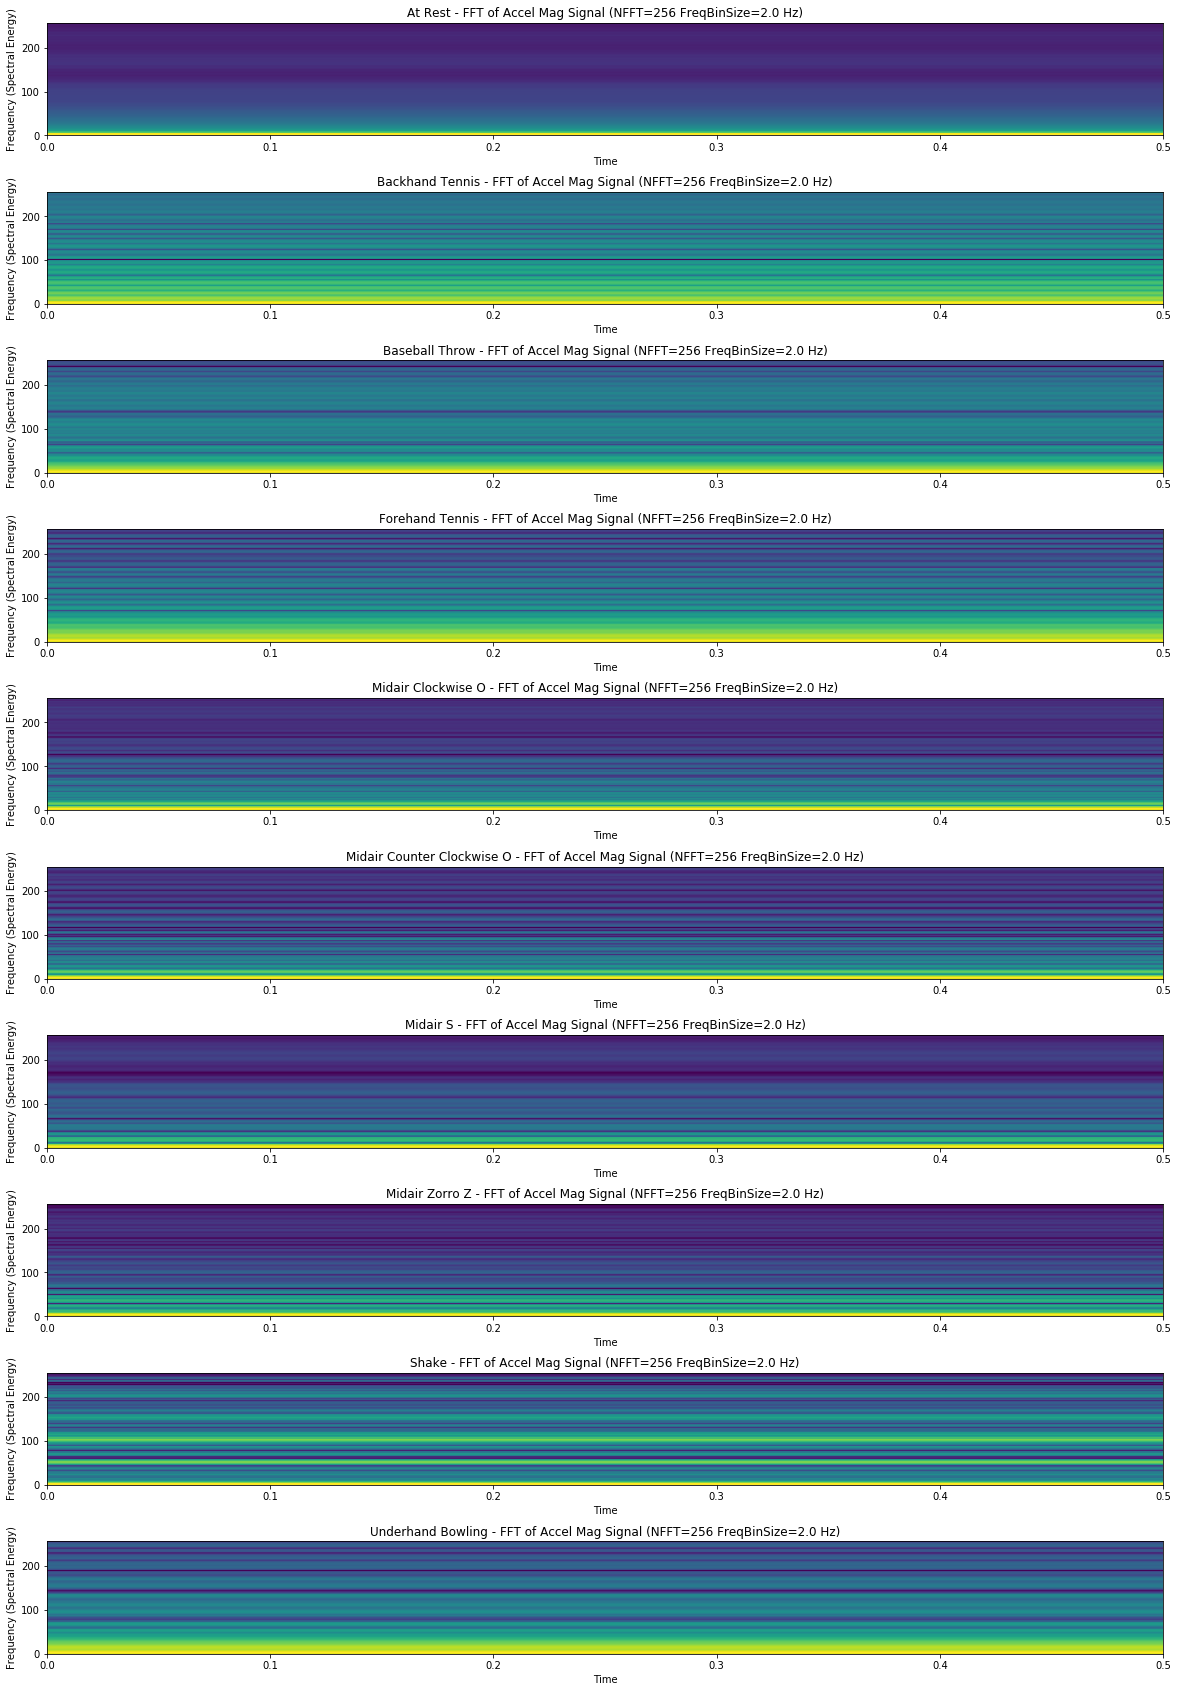

In [894]:
#Frequency Analysis visualization

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials_provided), 1, figsize=(20, 3 * len(mapGestureToTrials_provided)))
fig.subplots_adjust(hspace=0.5)

print("FFT Plots of Provided Gestures")
index = 0
gestureNamesSorted = sorted(mapGestureToTrials_provided.keys())
fftWindowSize = 256
samplingRate = 512
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials_provided[gestureName]
    
    for trial in gestureTrials:
        axes[index].specgram(trial.accel.mag, NFFT=fftWindowSize, Fs=samplingRate, noverlap=0)
        axes[index].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", 
        title='{} - FFT of Accel Mag Signal (NFFT={} FreqBinSize={} Hz)'.format(gestureName, fftWindowSize, samplingRate/fftWindowSize))
        
    index = index + 1

FFT Plots of My Recorded Gestures


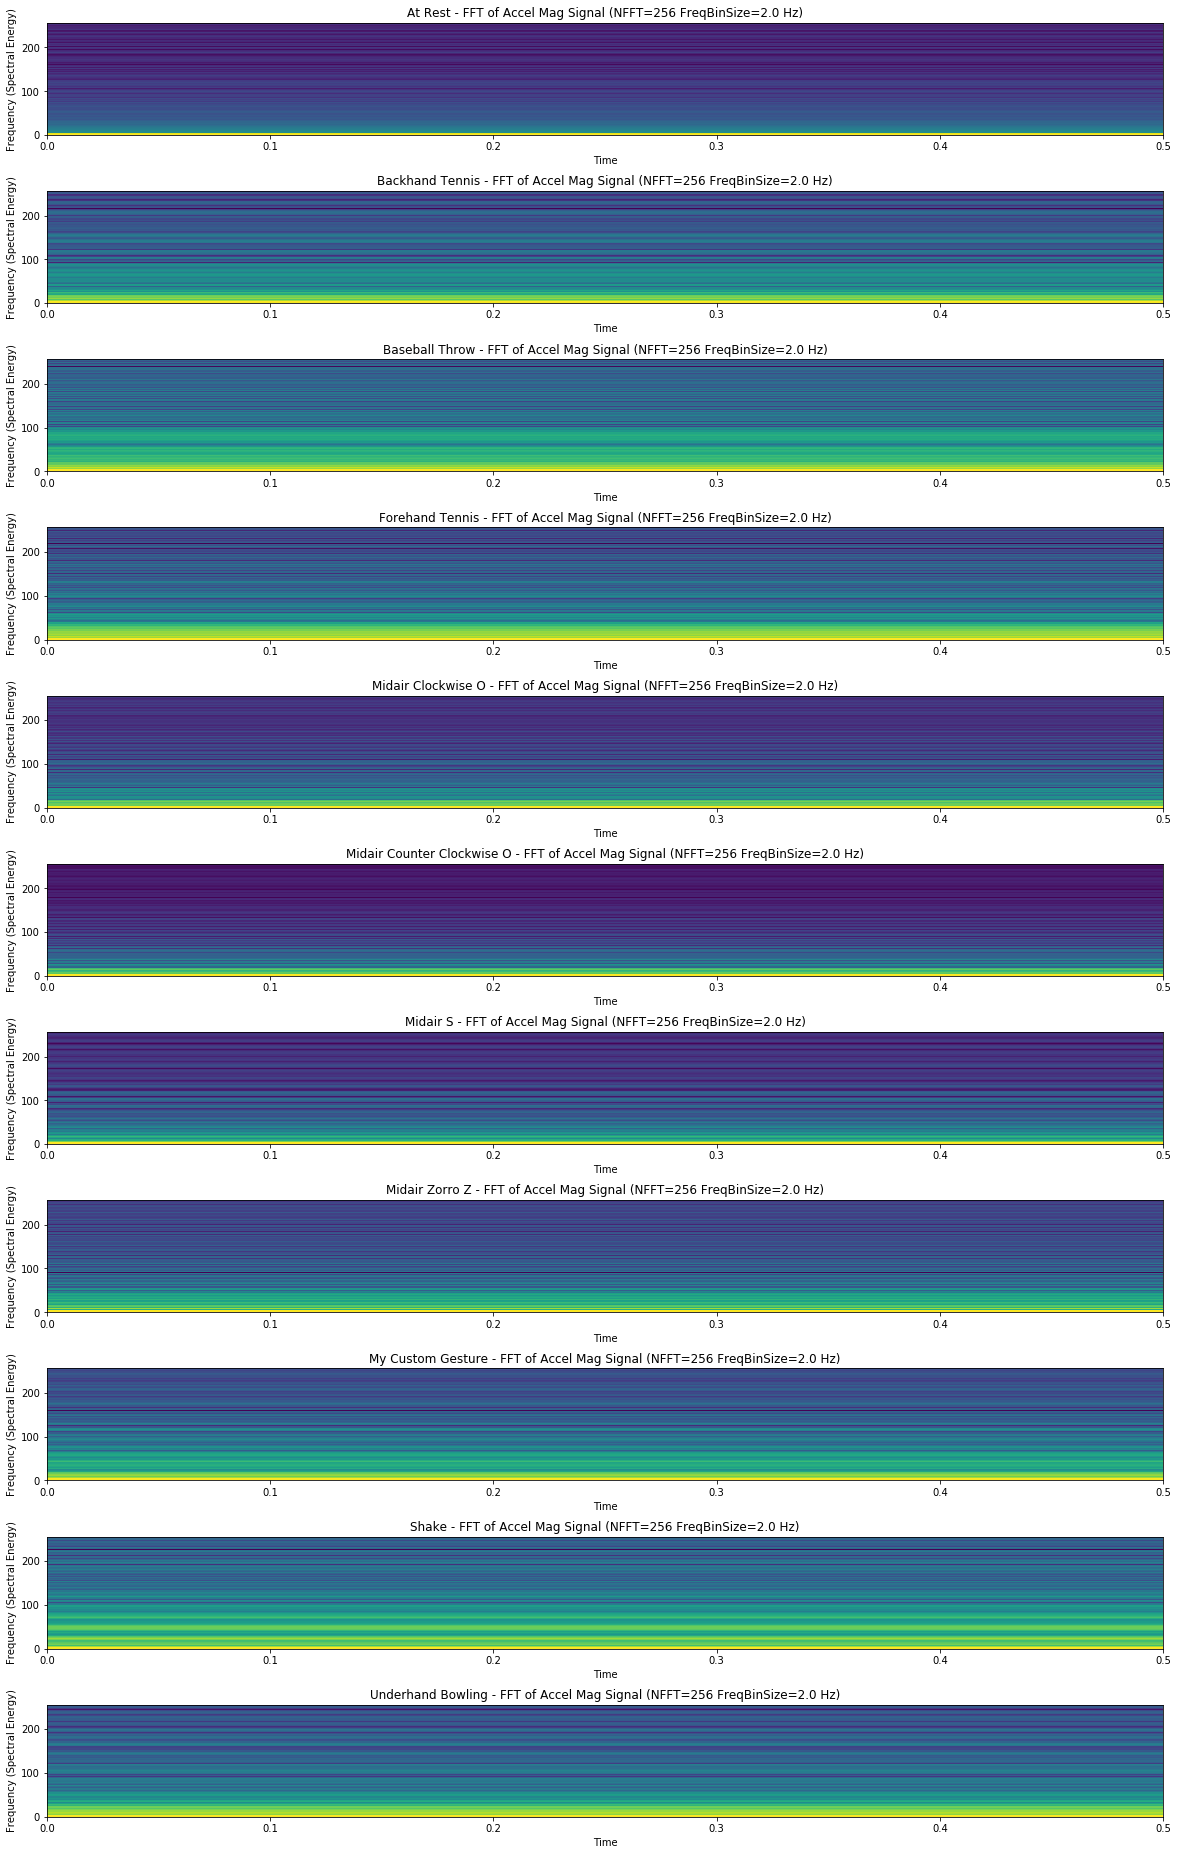

In [895]:
#Frequency Analysis visualization

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials_mine), 1, figsize=(20, 3 * len(mapGestureToTrials_mine)))
fig.subplots_adjust(hspace=0.5)

print("FFT Plots of My Recorded Gestures")
index = 0
gestureNamesSorted = sorted(mapGestureToTrials_mine.keys())
fftWindowSize = 256
samplingRate = 512
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials_mine[gestureName]
    
    for trial in gestureTrials:
        axes[index].specgram(trial.accel.mag, NFFT=fftWindowSize, Fs=samplingRate, noverlap=0)
        axes[index].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", 
        title='{} - FFT of Accel Mag Signal (NFFT={} FreqBinSize={} Hz)'.format(gestureName, fftWindowSize, samplingRate/fftWindowSize))
        
    index = index + 1

In [896]:
#SPLIT DATA INTO K-FOLDS

class FoldsItemClass:
    def __init__(self, gestureTrial):
        self.gestureTrial = gestureTrial
        self.bestScore = None
        self.bestMatch = None
        
    def update_best_match(self, score, match):
        if self.bestScore is None:
            self.bestScore = score
            self.bestMatch = match
        elif score < self.bestScore:
            self.bestScore = score
            self.bestMatch = match
            
import random

from random import randint

def get_random_order(orig):
    return sorted(orig, key = lambda x: random.random())


def generate_folds(mapGestureToTrials):
    gestureNamesSorted = sorted(mapGestureToTrials.keys())

    folds = [[],[],[],[],[]]

    for gestureName in gestureNamesSorted:
        trialIdxList = get_random_order(range(5))
        gestureTrials = mapGestureToTrials[gestureName]

        currIdx = 0
        for trialIdx in trialIdxList:
            foldItem = FoldsItemClass(gestureTrials[trialIdx])
            folds[currIdx].append(foldItem)
            currIdx += 1
            
    return folds

In [897]:
from scipy.spatial import distance

from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

def get_accel_gyro_scores_euclidean(gesture1, gesture2):
    return get_score_between_euclidean(gesture1.gestureTrial.accel.mag, gesture2.gestureTrial.accel.mag) + get_score_between_euclidean(gesture1.gestureTrial.gyro.mag, gesture2.gestureTrial.gyro.mag)
  
def get_accel_gyro_scores_dtw(gesture1, gesture2):
    return get_score_between_dtw(gesture1.gestureTrial.accel.mag, gesture2.gestureTrial.accel.mag) + get_score_between_dtw(gesture1.gestureTrial.gyro.mag, gesture2.gestureTrial.gyro.mag)
  
def get_score_between_euclidean(gesture1, gesture2):
    scipyDist = distance.euclidean(gesture2,gesture1)
    return scipyDist

def get_score_between_np(gesture1, gesture2):
    np1 = np.array(gesture1)
    np2 = np.array(gesture2)
    npDist = np.linalg.norm(np2 - np1)
    return npDist

def get_score_between_dtw(gesture1, gesture2):
    np1 = np.array(gesture1)
    np2 = np.array(gesture2)
    distance, path = fastdtw(np1, np2, dist=euclidean)
    return distance

def print_results_nicely(results, totalPerResult):
    score = 0
    resultKeys = results.keys()
    total = totalPerResult * len(results)
    print("")
    for resultKey in resultKeys:
        currScore = results[resultKey]
        score += currScore
        print("{0}: {1}/{2} ({3:.0f})%".format(resultKey, currScore, totalPerResult, (currScore/totalPerResult * 100)))
    print("")
    print("Total Accuracy: {0}/{1} ({2:.0f})%".format(score, total, (score/total * 100)))
        
#testing folds

def test_folds_shape_matching_euclidean(folds, mapGestureToTrials):
    y_true = []
    y_pred = []
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    overallResults = {elem:0 for elem in gestureNamesSorted}
    currTestFoldNum = 0
    fullRange = list(range(5))

    while (currTestFoldNum < 5):
        print("Testing Fold Num: #" + str(currTestFoldNum + 1))
        otherFolds = [cItem for cItem in fullRange if not cItem in [currTestFoldNum]]
        for currFoldGesture in folds[currTestFoldNum]:
            for otherFoldIdx in otherFolds:
                for otherFoldGesture in folds[otherFoldIdx]:
                    matchScore = get_accel_gyro_scores_euclidean(currFoldGesture, otherFoldGesture)
                    currFoldGesture.update_best_match(matchScore, otherFoldGesture.gestureTrial.gestureName)
            y_true.append(currFoldGesture.gestureTrial.gestureName)
            y_pred.append(currFoldGesture.bestMatch)
            if currFoldGesture.gestureTrial.gestureName == currFoldGesture.bestMatch: 
                overallResults[currFoldGesture.gestureTrial.gestureName] += 1
                #print(currFoldGesture.gestureTrial.gestureName)
        currTestFoldNum += 1

    print_results_nicely(overallResults, 5)
    return y_true, y_pred
                         
def test_folds_shape_matching_dtw(folds, mapGestureToTrials):
    y_true = []
    y_pred = []
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    overallResults = {elem:0 for elem in gestureNamesSorted}
    currTestFoldNum = 0
    fullRange = list(range(5))

    while (currTestFoldNum < 5):
        print("Testing Fold Num: #" + str(currTestFoldNum + 1))
        otherFolds = [cItem for cItem in fullRange if not cItem in [currTestFoldNum]]
        for currFoldGesture in folds[currTestFoldNum]:
            for otherFoldIdx in otherFolds:
                for otherFoldGesture in folds[otherFoldIdx]:
                    matchScore = get_accel_gyro_scores_dtw(currFoldGesture, otherFoldGesture)
                    currFoldGesture.update_best_match(matchScore, otherFoldGesture.gestureTrial.gestureName)
            y_true.append(currFoldGesture.gestureTrial.gestureName)
            y_pred.append(currFoldGesture.bestMatch)
            if currFoldGesture.gestureTrial.gestureName == currFoldGesture.bestMatch: 
                overallResults[currFoldGesture.gestureTrial.gestureName] += 1
                #print(currFoldGesture.gestureTrial.gestureName)
        currTestFoldNum += 1

    print_results_nicely(overallResults, 5)
    return y_true, y_pred
        

In [898]:
print("Provided Gestures - K-Fold Validation with Shape Matching")
foldsProvided = generate_folds(mapGestureToTrials_provided)
#y_true_prov, y_pred_prov = test_folds_shape_matching_euclidean(foldsProvided, mapGestureToTrials_provided)
y_true_prov, y_pred_prov = test_folds_shape_matching_dtw(foldsProvided, mapGestureToTrials_provided)

Provided Gestures - K-Fold Validation with Shape Matching
Testing Fold Num: #1
Testing Fold Num: #2
Testing Fold Num: #3
Testing Fold Num: #4
Testing Fold Num: #5

At Rest: 5/5 (100)%
Backhand Tennis: 5/5 (100)%
Baseball Throw: 5/5 (100)%
Forehand Tennis: 5/5 (100)%
Midair Clockwise O: 5/5 (100)%
Midair Counter Clockwise O: 5/5 (100)%
Midair S: 5/5 (100)%
Midair Zorro Z: 5/5 (100)%
Shake: 5/5 (100)%
Underhand Bowling: 4/5 (80)%

Total Accuracy: 49/50 (98)%


In [899]:
print("My Recorded Gestures - K-Fold Validation with Shape Matching")
foldsMine = generate_folds(mapGestureToTrials_mine)
#y_true_mine, y_pred_mine = test_folds_shape_matching_euclidean(foldsMine, mapGestureToTrials_mine)
y_true_mine, y_pred_mine = test_folds_shape_matching_dtw(foldsMine, mapGestureToTrials_mine)

My Recorded Gestures - K-Fold Validation with Shape Matching
Testing Fold Num: #1
Testing Fold Num: #2
Testing Fold Num: #3
Testing Fold Num: #4
Testing Fold Num: #5

At Rest: 5/5 (100)%
Backhand Tennis: 5/5 (100)%
Baseball Throw: 5/5 (100)%
Forehand Tennis: 5/5 (100)%
Midair Clockwise O: 5/5 (100)%
Midair Counter Clockwise O: 5/5 (100)%
Midair S: 5/5 (100)%
Midair Zorro Z: 5/5 (100)%
My Custom Gesture: 5/5 (100)%
Shake: 5/5 (100)%
Underhand Bowling: 5/5 (100)%

Total Accuracy: 55/55 (100)%


In [900]:
# Confusion Matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 1 0 0 0 0 0 4]]
Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.8]]


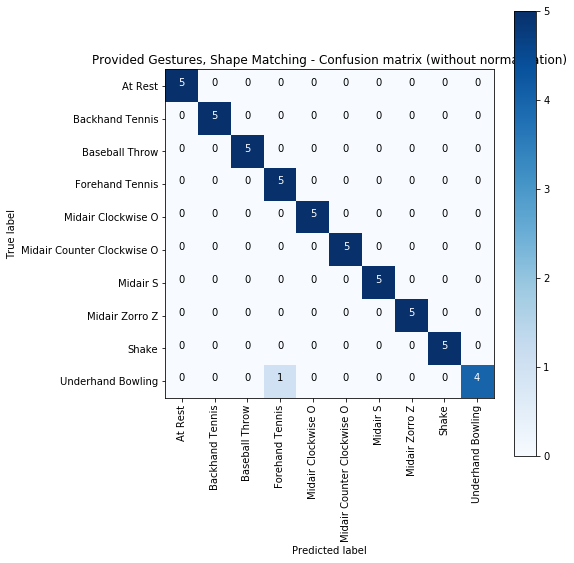

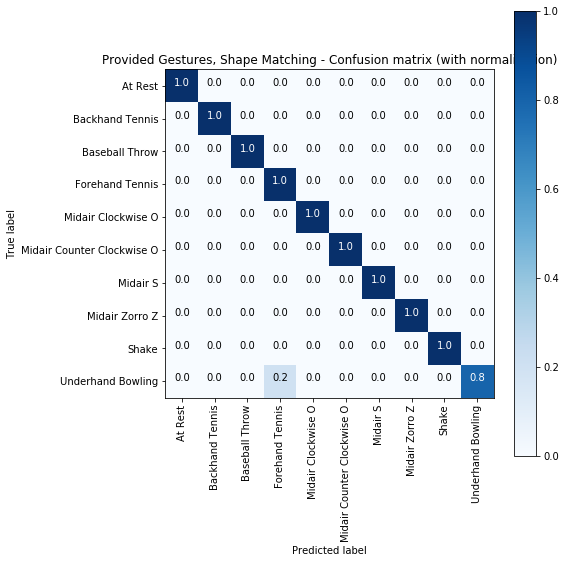

In [901]:
labels_prov = sorted(mapGestureToTrials_provided.keys())

cm = confusion_matrix(y_true_prov, y_pred_prov, labels_prov)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels_prov,
                      title='Provided Gestures, Shape Matching - Confusion matrix (without normalization)')

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels_prov, normalize=True,
                      title='Provided Gestures, Shape Matching - Confusion matrix (with normalization)')
plt.show()

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


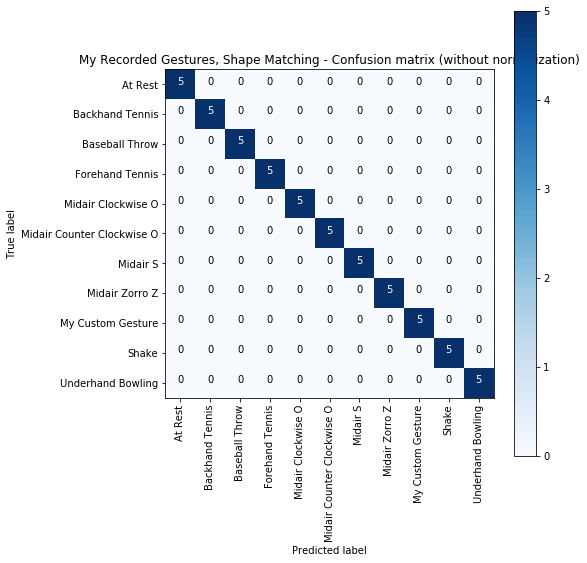

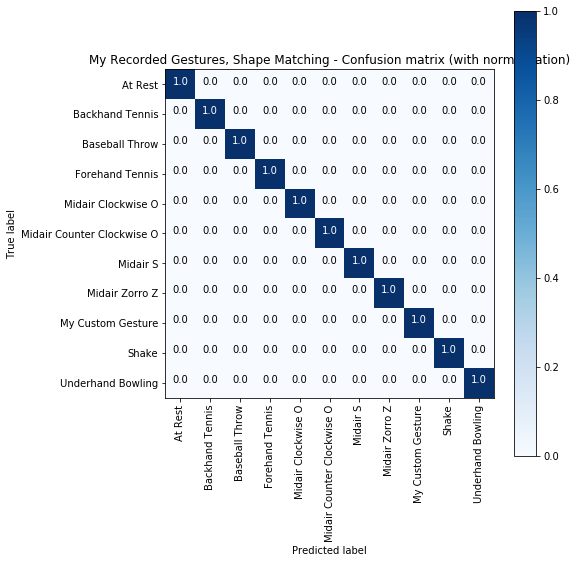

In [902]:
labels_mine = sorted(mapGestureToTrials_mine.keys())

cm = confusion_matrix(y_true_mine, y_pred_mine, labels_mine)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels_mine,
                      title='My Recorded Gestures, Shape Matching - Confusion matrix (without normalization)')

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels_mine, normalize=True,
                      title='My Recorded Gestures, Shape Matching - Confusion matrix (with normalization)')
plt.show()

In [903]:
#KFold Prep

# Given the online discussion about k-fold implementations, I thought I would provide my own. Note that sci-kit learn also 
# has built-in functionality for this (I've never used it but worth checking out):
# http://scikit-learn.org/stable/modules/cross_validation.html
from random import randint

# Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial for that fold
# if createNewKFold is True, returns a new random fold, otherwise returns same fold setup as before 
# (this is to better enable repeat experimentation)
def generate_kfolds(mapGestureToTrials, numFolds=5, createNewKFold=False):
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gestureName, trials in mapGestureToTrials.items():
        if numFolds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(numFolds, gestureName, len(trials)))


    numGestures = len(mapGestureToTrials)
    #print("num gest {}".format(numGestures))
    tmpMapGestureToTrials = dict()
    for gestureName, trials in mapGestureToTrials.items():
        tmpMapGestureToTrials[gestureName] = list(trials)
    
    gestureNames = list(mapGestureToTrials.keys())

    # create folds
    foldToMapGestureToTrial = list()
    for i in range(0, numFolds):
        curFoldMapGestureToTrial = dict()
        foldToMapGestureToTrial.append(curFoldMapGestureToTrial)
        
        for j in range(0, numGestures):
            curGestureName = gestureNames[j]
            trialList = tmpMapGestureToTrials[curGestureName]
            randTrialIndex = 0
            if (len(trialList) > 0):
                randTrialIndex = randint(0, len(trialList) - 1)

            randTrial = trialList[randTrialIndex]
            curFoldMapGestureToTrial[curGestureName] = randTrial
            del trialList[randTrialIndex]
    
    return foldToMapGestureToTrial

def debug_print_folds(foldToMapGestureToTrial):
    # debug check folds
    foldIndex = 0
    print("DEBUG: PRINTING OUT FOLDS")
    for fold in foldToMapGestureToTrial:
        print("Fold: ", foldIndex)
        for gestureName, trial in fold.items():
            print("\t Gesture: {} Trial: {}".format(gestureName, trial.trialNum))
        foldIndex = foldIndex + 1

In [904]:
# Kfold validation with Feature-based recognizer, SVM
from sklearn import svm
import random

import scipy as sy
import scipy.fftpack as syfp

#https://stackoverflow.com/questions/26105698/how-to-calculate-frequency-of-a-give-wave-and-time
def get_max_freqs(listToMeasure):
    dt = 0.02071 
    fft_raw = sy.fft(listToMeasure)
    freqs = syfp.fftfreq(len(listToMeasure), dt) 
    return np.real(fft_raw.max()), freqs.max()


def count_zero_crossings(listToCount):
    counter = 0
    for i in range(len(listToCount)-1):
        if listToCount[i] > 0 and listToCount[i+1] < 0:
            counter +=1
    #print(counter)
    return counter

# create_feature_vector function that returns a 3D feature vector for the given trial        
def create_simple_feature_vector(trial):
    count_zero_x = count_zero_crossings(trial.accel.xorig)
    count_zero_y = count_zero_crossings(trial.accel.yorig)
    count_zero_z = count_zero_crossings(trial.accel.zorig)
    count_zero_g_x = count_zero_crossings(trial.gyro.xorig)
    count_zero_g_y = count_zero_crossings(trial.gyro.yorig)
    count_zero_g_z = count_zero_crossings(trial.gyro.zorig)
    
    fft_max_x, freq_max_x = get_max_freqs(trial.accel.xorig)
    fft_max_y, freq_max_y = get_max_freqs(trial.accel.yorig)
    fft_max_z, freq_max_z = get_max_freqs(trial.accel.zorig)
    fft_max_g_x, freq_max_g_x = get_max_freqs(trial.gyro.xorig)
    fft_max_g_y, freq_max_g_y = get_max_freqs(trial.gyro.yorig)
    fft_max_g_z, freq_max_g_z = get_max_freqs(trial.gyro.zorig)
    
    #print(fft_max_x) #this reduced the accuracy
    #print(freq_max_x)

    return [trial.accel.mag.mean(), trial.gyro.mag.mean(), 
           trial.accel.mag.std(), trial.gyro.mag.std(),
           count_zero_x, count_zero_y, count_zero_z,
           count_zero_g_x, count_zero_g_y, count_zero_g_z,
           freq_max_x,
           freq_max_y,
           freq_max_z,
           freq_max_g_x,
           freq_max_g_y,
           freq_max_g_z, 
           trial.accel.xorig.mean(), trial.gyro.xorig.mean(),
           trial.accel.yorig.mean(), trial.gyro.yorig.mean(),
           trial.accel.zorig.mean(), trial.gyro.zorig.mean(),
           trial.accel.xorig.std(), trial.gyro.xorig.std(),
           trial.accel.yorig.std(), trial.gyro.yorig.std(),
           trial.accel.zorig.std(), trial.gyro.zorig.std()]          

# First attempt at create_feature_vector function that returns a 3D feature vector for the given trial        
def create_simple_feature_vector_old(trial):
    return [trial.accel.mag.max(), trial.accel.signalLengthBeforePadding, trial.gyro.mag.max(),
           count_zero_x, count_zero_y, count_zero_z,
           count_zero_g_x, count_zero_g_y, count_zero_g_z,
           trial.accel.mag.min(),trial.gyro.mag.min(),
           trial.accel.mag.mean(),trial.gyro.mag.mean(), 
           trial.accel.mag.std(),trial.gyro.mag.std(), 
           trial.accel.mag.ptp(),trial.gyro.mag.ptp(), 
           trial.accel.xorig.max(), trial.gyro.xorig.max(),
           trial.accel.yorig.max(), trial.gyro.yorig.max(),
           trial.accel.zorig.max(), trial.gyro.zorig.max(), 
           trial.accel.xorig.mean(), trial.gyro.xorig.mean(),
           trial.accel.yorig.mean(), trial.gyro.yorig.mean(),
           trial.accel.zorig.mean(), trial.gyro.zorig.mean(),
           trial.accel.xorig.std(), trial.gyro.xorig.std(),
           trial.accel.yorig.std(), trial.gyro.yorig.std(),
           trial.accel.zorig.std(), trial.gyro.zorig.std(),
           trial.accel.xorig.ptp(), trial.gyro.xorig.ptp(),
           trial.accel.yorig.ptp(), trial.gyro.yorig.ptp(),
           trial.accel.zorig.ptp(), trial.gyro.zorig.ptp()] 

# takes in the current testFold, the trainingFolds, and a create_feature_vector function
# the create_feature_vector function creates feature vectors given a Trial object
def get_svm_input(testFold, trainingFolds, create_feature_vector):
    
    # calculate the number of training trials
    numOfTrainingTrials = 0
    for trainingFold in trainingFolds:
        numOfTrainingTrials = numOfTrainingTrials + len(trainingFold)
        
    # Now figure out the number of features from the create_feature_vector call
    # This is just a dummy call to figure out the number of features in order to
    # properly initialize our trainingData matrix
    tmpTrainingTrial = random.choice(list(trainingFolds[0].values()))
    numFeatures = len(create_feature_vector(tmpTrainingTrial))
    #print("The feature vector size is: {}".format(numFeatures))
     
    # now we can setup our training data structures  
    # each row in our trainingData matrix corresponds to a trial
    # and each column corresponds to a feature
    trainingData = np.zeros([numOfTrainingTrials, numFeatures])
    trainingTrials = list()
    trainingLabels = np.array([])
  
    # Build up the training data and also keep track of the class labels (in trainingLabels)
    row = 0
    for trainingFold in trainingFolds:
        for trainingGestureName, trainingTrial in trainingFold.items():
            trainingData[row] = create_feature_vector(trainingTrial)
            trainingLabels = np.append(trainingLabels, trainingTrial.gestureName)
            trainingTrials.append(trainingTrial)
            row = row + 1
    
    # Now setup the testData data structure
    testData = np.zeros([len(testFold), numFeatures])
    testRow = 0
    groundtruthLabels = list()
    testTrials = list()
    for testGestureName, testTrial in testFold.items():
        testTrials.append(testTrial)
        testData[testRow] = create_feature_vector(testTrial)
        groundtruthLabels.append(testGestureName)
        testRow = testRow + 1
        
    return trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials

In [905]:
#computing the SVM predictions

def test_folds_svm(mapGestureToTrials, numFolds):
    foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials, numFolds)
    #debug_print_folds(foldToMapGestureToTrial)

    fullRange = list(range(5))
    currTestFoldNum = 0
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    overallResults = {elem:0 for elem in gestureNamesSorted}
    y_true = []
    y_pred = []

    while (currTestFoldNum < numFolds):
        print("Testing Fold Num: #" + str(currTestFoldNum + 1))    
        testFold = foldToMapGestureToTrial[currTestFoldNum]
        trainingFolds = [foldToMapGestureToTrial[cItem] for cItem in fullRange if not cItem in [currTestFoldNum]]

        svmInput = get_svm_input(testFold, trainingFolds, create_simple_feature_vector)
        trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials = svmInput

        # Training our SVM
        clf = svm.SVC()
        clf.fit(trainingData, trainingLabels) 
        svmPrediction = clf.predict(testData)
        #print("SVM actual: {}".format(groundtruthLabels))
        #print("")
        #print("SVM prediction: {}".format(svmPrediction))
        
        y_true.extend(groundtruthLabels)
        y_pred.extend(svmPrediction)
        idx = 0
        while idx < len(groundtruthLabels):
            if groundtruthLabels[idx] == svmPrediction[idx]: 
                overallResults[svmPrediction[idx]] += 1
            idx += 1
        currTestFoldNum += 1    
    
    print_results_nicely(overallResults, numFolds)
    return y_true, y_pred
    

In [906]:
print("Provided Gestures - K-Fold Validation with SVM")
y_true_prov, y_pred_prov = test_folds_svm(mapGestureToTrials_provided, 5)

Provided Gestures - K-Fold Validation with SVM
Testing Fold Num: #1
Testing Fold Num: #2
Testing Fold Num: #3
Testing Fold Num: #4
Testing Fold Num: #5

At Rest: 5/5 (100)%
Backhand Tennis: 5/5 (100)%
Baseball Throw: 5/5 (100)%
Forehand Tennis: 5/5 (100)%
Midair Clockwise O: 5/5 (100)%
Midair Counter Clockwise O: 5/5 (100)%
Midair S: 5/5 (100)%
Midair Zorro Z: 4/5 (80)%
Shake: 3/5 (60)%
Underhand Bowling: 5/5 (100)%

Total Accuracy: 47/50 (94)%


In [907]:
print("My Recorded Gestures - K-Fold Validation with SVM")
y_true_mine, y_pred_mine = test_folds_svm(mapGestureToTrials_mine, 5)

My Recorded Gestures - K-Fold Validation with SVM
Testing Fold Num: #1
Testing Fold Num: #2
Testing Fold Num: #3
Testing Fold Num: #4
Testing Fold Num: #5

At Rest: 5/5 (100)%
Backhand Tennis: 4/5 (80)%
Baseball Throw: 4/5 (80)%
Forehand Tennis: 5/5 (100)%
Midair Clockwise O: 5/5 (100)%
Midair Counter Clockwise O: 5/5 (100)%
Midair S: 5/5 (100)%
Midair Zorro Z: 5/5 (100)%
My Custom Gesture: 5/5 (100)%
Shake: 5/5 (100)%
Underhand Bowling: 5/5 (100)%

Total Accuracy: 53/55 (96)%


Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [1 0 0 0 0 0 0 4 0 0]
 [2 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.2 0.  0.  0.  0.  0.  0.  0.8 0.  0. ]
 [0.4 0.  0.  0.  0.  0.  0.  0.  0.6 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


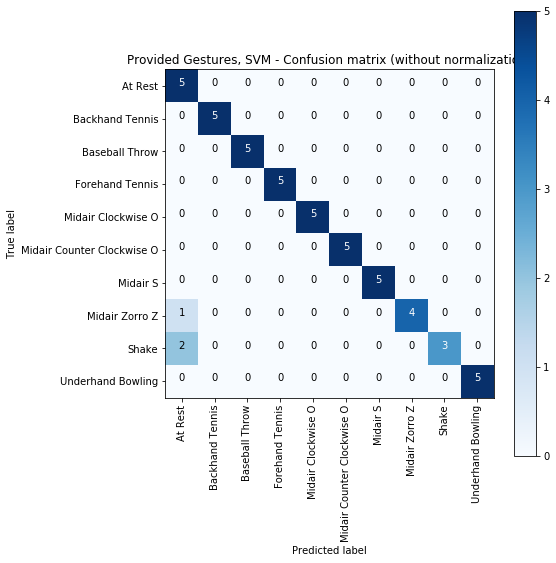

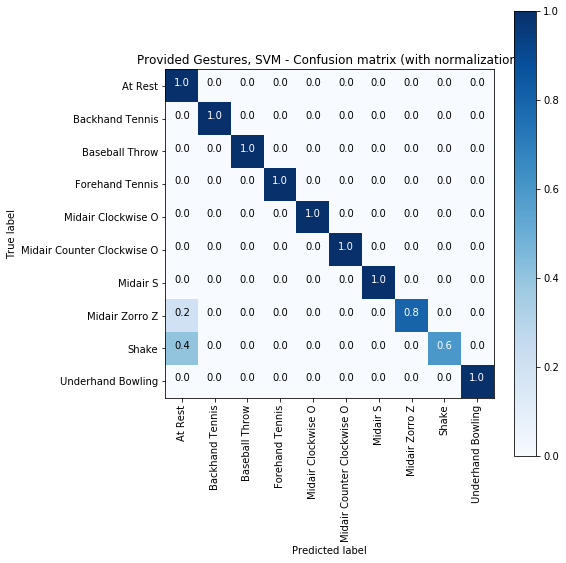

In [908]:
cm = confusion_matrix(y_true_prov, y_pred_prov, labels_prov)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels_prov,
                      title='Provided Gestures, SVM - Confusion matrix (without normalization)')

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels_prov, normalize=True,
                      title='Provided Gestures, SVM - Confusion matrix (with normalization)')
plt.show()

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 1 0 0 0 0 0 0 0]
 [0 0 4 1 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.8 0.  0.2 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.8 0.2 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


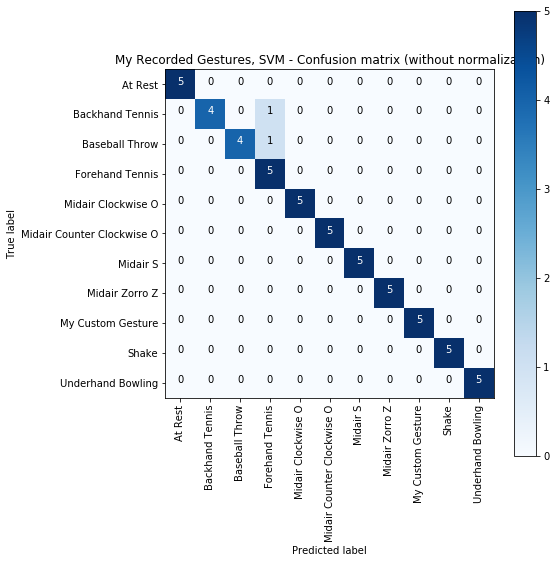

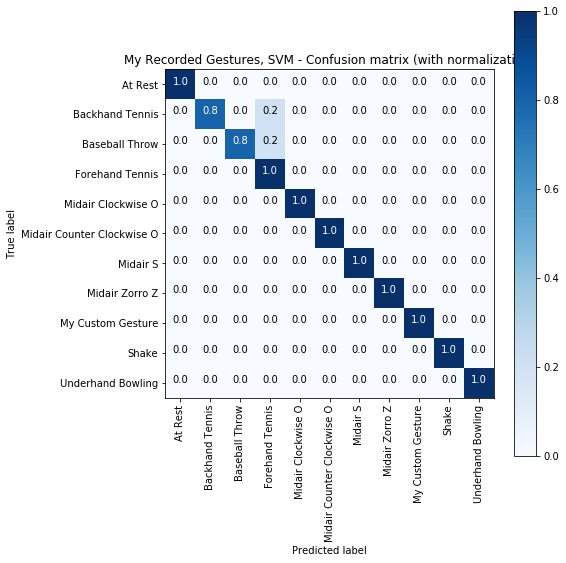

In [909]:
cm = confusion_matrix(y_true_mine, y_pred_mine, labels_mine)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels_mine,
                      title='My Recorded Gestures, SVM - Confusion matrix (without normalization)')

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=labels_mine, normalize=True,
                      title='My Recorded Gestures, SVM - Confusion matrix (with normalization)')
plt.show()